## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

#from direct_collocation_opti  import MpcProblem
#from KinematicModel  import KinematicBicycle

from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
#from complex_track_2                import complex_track_2 as test_road
#from complex_track_2                import complex_track_2_width as test_road_width
#from road_with_obstruction import road_with_obstruction as test_road
#from road_with_obstruction import road_with_obstruction_width as test_road_width

# Generates a totally straight test_road
#test_road = np.empty((100,2))
#for i in range(100):
#    test_road[i,0] = i
#    test_road[i,1] = -0.001*i if i > 60 else 0.001*i

# Flips the test road, so the car goes from the end to the start.
#test_road = np.flip(test_road, 0)


## Initialize the car and road model

In [2]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)
DESIRED_SPEED = 10.0
step = 0.075
N = 40

In [3]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

 [ 0.]] is [15.28968758] away at s = 0.012034637828942558, B(s) = [[9.96891533e+00]
 [1.83244721e-17]]
 [ 0.]] is [15.72259511] away at s = 0.02457308184468577, B(s) = [[2.00139878e+01]
 [1.77563205e-12]]
 [ 0.]] is [14.52614119] away at s = 0.03849461062298814, B(s) = [[3.00576112e+01]
 [1.75676151e-09]]
 [ 0.]] is [13.55609329] away at s = 0.05475452436113872, B(s) = [[3.99630405e+01]
 [2.95790905e-07]]
 [ 0.]] is [12.98917298] away at s = 0.06433647905010509, B(s) = [[4.50321205e+01]
 [2.75208340e-06]]
 [ 0.]] is [13.27543701] away at s = 0.07448072291292603, B(s) = [[4.99651086e+01]
 [1.92866944e-05]]
 [ 0.]] is [13.31075205] away at s = 0.08558755713960864, B(s) = [[5.50201211e+01]
 [1.13143616e-04]]
 [ 0.]] is [12.97499973] away at s = 0.09719331377081405, B(s) = [[6.00508873e+01]
 [5.28653028e-04]]
 [ 0.]] is [12.41360199] away at s = 0.10905299814632262, B(s) = [[6.50040919e+01]
 [1.98814312e-03]]
 [ 0.]] is [11.93208638] away at s = 0.12143317349514081, B(s) = [[6.99918889e+01

## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [4]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

## Run the MPC algorithm

In [5]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic, desired_speed, roadrunner)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car, roadrunner,  )
#mpcprob = MpcProblem(KinematicBicycle("base_vehicle_model.json"),
#                                      roadrunner,step, N, desired_speed )

Starting at initial conditions [-41.805813255858155, 1.2830056666455753e-07, 10.0, 6.170791942483788e-08]


<IPython.core.display.Javascript object>


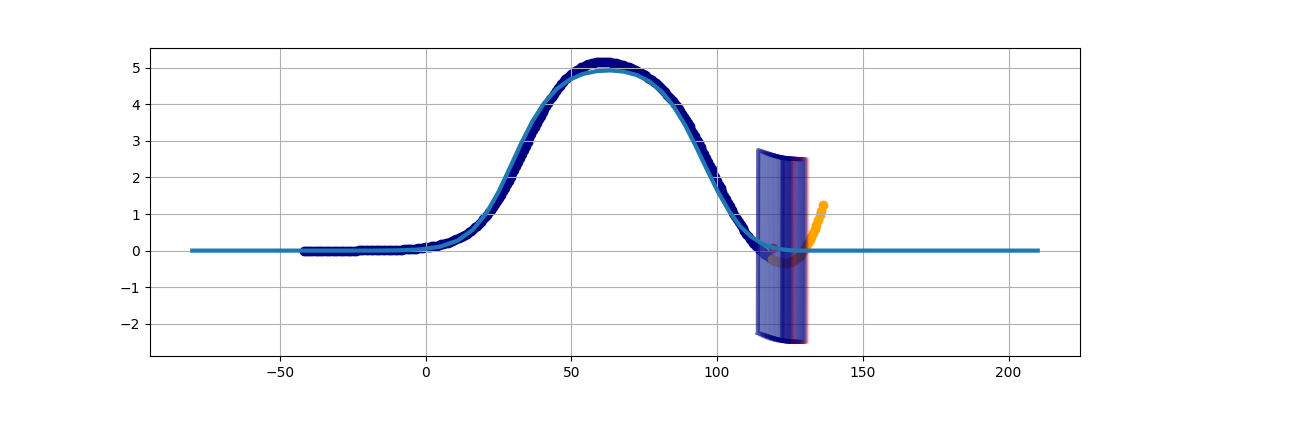


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/direct_collocation.py:277: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  est[:,i] = np.array([xy[0,0], xy[0,1], self.model.desired_speed(i), angle])


In [ ]:
%matplotlib notebook

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs =5000

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
centers = np.zeros((4,n_runs+1)) # store the state as simulated for each control input by an integrator
centers[:,0] = [ic[0], ic[1], ic[3], ic[2]] # stupid indexing difference, sorry
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+N,4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(x_true[0,0], x_true[1,0], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
mpcprob.model.u_upper = 0.0
try:
    while k < n_runs:
        # Solve the MPC problem
        xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
        
        # for plotting
        centers[:,k+1] = mpcprob.x_center_plot[:,1]
        
        
        # Save the next state x_k+1 and control u_k+1
        for i in range(mpcprob.model.n):
            x_plan[i,k+1] = xk_opt[i][1]
        for i in range(mpcprob.model.m):
            u_plan[i,k] = uk_opt[i][1]
        x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

        # Compute distance traveled (approximately)
        step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2)

        # Save the 4 points that represent the polygon boundary at state k
        bounds,p = roadrunner.bound_x(mpcprob.model.step,0, desired_speed)
        polygon_boundaries[k,:,:] = p
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())


        # Plot arrows and x-y states
        ax_traj.clear()
        #ax_traj.quiver(x_true[0,:k], x_true[1,:k], x_true[2,:k]*np.cos(x_true[3,:k]), x_true[2,:k]*np.sin(x_true[3,:k]), color="blue")
        ax_traj.scatter(x_true[0,:k], x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        ax_traj.scatter(xy[0], xy[1], color="red")
        # Plot the polygon fill
        ax_traj.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)

        # Plot the plan
        for r in range(30-1):
            # Plot the polygon fill
            #ax_traj.fill(mpcprob.p_plot[r,:,0], mpcprob.p_plot[r,:,1], "lightblue", alpha=0.1)
            # Plot the line around each polygon
            ax_traj.plot(np.concatenate([mpcprob.p_plot[r,:,0],mpcprob.p_plot[r,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[r,:,1],mpcprob.p_plot[r,0:1,1]]),
                    color="navy", alpha=0.2)
        ax_traj.plot(np.concatenate([mpcprob.p_plot[-1,:,0],mpcprob.p_plot[-1,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[-1,:,1],mpcprob.p_plot[-1,0:1,1]]),
                    color="red", alpha=0.2)


        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")

        roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1
        if k <= 25:
            mpcprob.model.u_upper += 0.1 # it will go up to the limit of 2.5
            # because for some reason it really wants to speed up right away which is weird

except OutOfRoadPointsException as e:
    print(e)
    x_plan = x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
    u_plan = u_plan[:,:k]  
    x_true = x_true[:,k+1]
    centers = centers[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
finally:
    fig_traj.canvas.draw()


In [ ]:
# turn interactive off
plt.ioff()
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[k-1:k+mpcprob.model.N,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

In [ ]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(u_plan, mpcprob.u_opt, step, N)
plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

In [ ]:
from KinematicBicycleCar import plot_x
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt, step, N)
    
roadrunner.plot(ax=x_ax, n_points=50)
plt.show()

## x vs time and y vs time, separately, with the boundaries

In [ ]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1)
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.25)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=0.5)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()

In [ ]:
def plot_x(x_executed:np.array, x_planned:np.array):
    fig2, ax = plt.subplots(1,1,
        figsize=(14, 6))

    # Plot the last optimal path computed
    tgrid = np.linspace(0, mpcprob.model.T, mpcprob.model.N)
    vx_plan = np.multiply(x_planned[2],np.cos(x_planned[3]))
    vy_plan = np.multiply(x_planned[2],np.sin(x_planned[3]))

    # Plot the x given
    tgrid = np.linspace(0, mpcprob.model.T, len(x_executed[0]))
    vx_exec = np.multiply(x_executed[2],np.cos(x_executed[3]))
    vy_exec = np.multiply(x_executed[2],np.sin(x_executed[3]))
    # The first 2 states in the planned vector are also in the executed vector
    # since the first state is the initial state (the one we were at)
    # and the second one gets executed, therefore stored in the executed vector
    # to become the next run's initial state. This is why we slice vx_plan, vy_plan.
    vx = np.concatenate([vx_exec, vx_plan[2:]])
    vy = np.concatenate([vy_exec, vy_plan[2:]])
    ax.plot(np.sqrt(vx**2 + vy**2), color="blue")
    
    xs = np.concatenate([x_executed[0], x_planned[0,2:]])
    
    fig2.suptitle("Velocity")

    return fig2, ax
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt)
plt.show()